In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score
from torch.nn.functional import softmax
import torch
import pandas as pd
import json
from sklearn.model_selection import train_test_split


In [10]:
with open("etiketli_yorumlar_mistral.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data["reviews"])
X = df["comment"]
y = df["label"]


In [11]:
from sklearn.utils import resample
import pandas as pd

# Orijinal dataframe (yorum + etiket)
df_minority = df[df["label"] == 2]  # Negatif
df_neutral = df[df["label"] == 0]   # Nötr
df_majority = df[df["label"] == 1]  # Pozitif

# Oversample minority to match majority
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_neutral_upsampled = resample(df_neutral, 
                                replace=True,
                                n_samples=len(df_majority),
                                random_state=42)

# Birleştir
df_balanced = pd.concat([df_majority, df_neutral_upsampled, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42)  # Shuffle

print(df_balanced["label"].value_counts())


label
1    60
2    60
0    60
Name: count, dtype: int64


In [12]:
X = df_balanced["comment"]
y = df_balanced["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [13]:
model_name = "savasy/bert-base-turkish-sentiment-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


In [14]:
def bert_sentiment(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1)
    bert_labels = torch.argmax(probs, dim=1).numpy()
    # Orijinal sıralama: 0=negatif, 1=nötr, 2=pozitif → Bizim için: 2=negatif, 0=nötr, 1=pozitif
    conversion = {0: 2, 1: 0, 2: 1}  # Yeni etiket haritası
    mapped = [conversion[int(label)] for label in bert_labels]
    return mapped


In [15]:
y_pred = bert_sentiment(X_test.tolist())

print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))


🎯 Accuracy: 0.5277777777777778

📊 Classification Report:

              precision    recall  f1-score   support

           0      0.438     0.583     0.500        12
           1      0.000     0.000     0.000        12
           2      0.600     1.000     0.750        12

    accuracy                          0.528        36
   macro avg      0.346     0.528     0.417        36
weighted avg      0.346     0.528     0.417        36



c:\Users\ŞEVVAL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ŞEVVAL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ŞEVVAL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

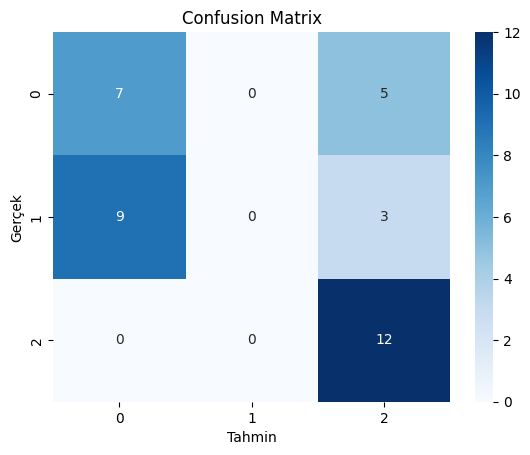

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()


In [17]:
# Örnek yorumlar
yorumlar = [
    "Ürün elime ulaştı, henüz denemedim.",           # Nötr
    "Kargo hızlı geldi, paketleme harikaydı.",       # Pozitif
    "Çalışmadı, hemen iade ettim.",                  # Negatif
    "Kullandım, fena değil ama pek bir şey hissettirmedi.",  # Nötr
    "Beklentimin çok üzerinde bir ürün.",            # Pozitif
    "Kırık geldi, müşteri hizmetleri de ilgilenmedi." # Negatif
]

# Tahmin et
tahminler = bert_sentiment(yorumlar)
etiket_map = {0: "Nötr", 1: "Pozitif", 2: "Negatif"}

# Sonuçları yazdır
for yorum, etiket in zip(yorumlar, tahminler):
    print(f"📝 Yorum: {yorum}\n🔍 Tahmin: {etiket_map[etiket]}\n")


📝 Yorum: Ürün elime ulaştı, henüz denemedim.
🔍 Tahmin: Negatif

📝 Yorum: Kargo hızlı geldi, paketleme harikaydı.
🔍 Tahmin: Nötr

📝 Yorum: Çalışmadı, hemen iade ettim.
🔍 Tahmin: Negatif

📝 Yorum: Kullandım, fena değil ama pek bir şey hissettirmedi.
🔍 Tahmin: Negatif

📝 Yorum: Beklentimin çok üzerinde bir ürün.
🔍 Tahmin: Negatif

📝 Yorum: Kırık geldi, müşteri hizmetleri de ilgilenmedi.
🔍 Tahmin: Negatif



In [18]:
def bert_sentiment_raw(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1)
    return torch.argmax(probs, dim=1).numpy()

# Tahminleri gerçek (BERT’in kendi etiketleriyle) göre al
tahminler_raw = bert_sentiment_raw(yorumlar)
etiket_map_raw = {0: "Negatif", 1: "Nötr", 2: "Pozitif"}

for yorum, etiket in zip(yorumlar, tahminler_raw):
    print(f"📝 Yorum: {yorum}\n🔍 BERT Tahmini: {etiket_map_raw[etiket]}\n")


📝 Yorum: Ürün elime ulaştı, henüz denemedim.
🔍 BERT Tahmini: Negatif

📝 Yorum: Kargo hızlı geldi, paketleme harikaydı.
🔍 BERT Tahmini: Nötr

📝 Yorum: Çalışmadı, hemen iade ettim.
🔍 BERT Tahmini: Negatif

📝 Yorum: Kullandım, fena değil ama pek bir şey hissettirmedi.
🔍 BERT Tahmini: Negatif

📝 Yorum: Beklentimin çok üzerinde bir ürün.
🔍 BERT Tahmini: Negatif

📝 Yorum: Kırık geldi, müşteri hizmetleri de ilgilenmedi.
🔍 BERT Tahmini: Negatif

